# BAYESIAN COMMODITY FUTURES INDICES

## Imports

In [1]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sbn
import numpy             as np
import pyflux            as pf

from helpers                       import best_of
from itertools                     import product
from pandas.tools.plotting         import autocorrelation_plot
from scipy.stats                   import expon, laplace, t
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.collections        import PolyCollection

## Notebook  Settings

In [2]:
%matplotlib notebook
sbn.set_style('whitegrid')

## Read and Fix Data

In [3]:
dat_file = './data/CommodityIndices.xlsx'
skiprows = (2, 3, 4, 5)
raw_data = pd.read_excel(dat_file, skiprows=skiprows, index_col=0, parse_cols='B:AE')

raw_data.columns = [column[4:-2].rstrip() for column in raw_data.columns]
raw_data.iloc[0] = 100.0

## Index, Returns, and Volatility
Pick any index by name

In [4]:
raw_data.columns.values.tolist()

['Commodity',
 'Energy',
 'Precious Metals',
 'Industrial Metals',
 'Agriculture',
 'Livestock',
 'WTI Crude Oil',
 'Brent Crude',
 'Heat Oil',
 'Unleaded Gas',
 'Natural Gas',
 'Aluminum',
 'Copper',
 'Nickel',
 'Zinc',
 'Gold',
 'Silver',
 'Wheat',
 'Kansas Wheat',
 'Corn',
 'Soybeans',
 'Soybean Oil',
 'Soybean Meal',
 'Cotton',
 'Sugar',
 'Coffee',
 'Cocoa',
 'Live Cattle',
 'Lean Hogs']

<IPython.core.display.Javascript object>


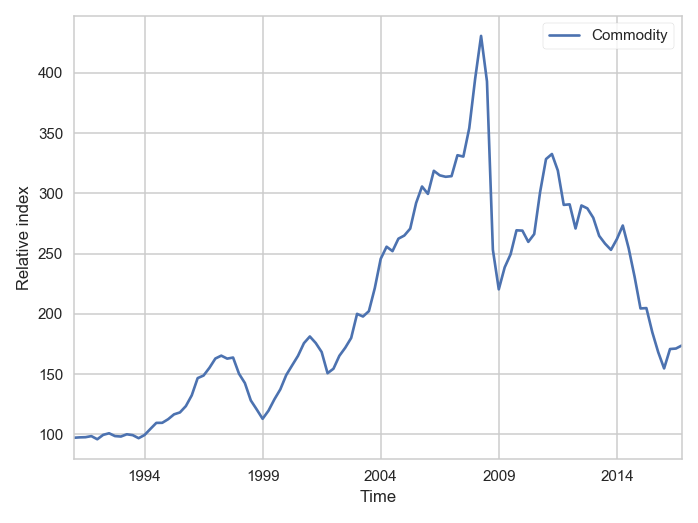

In [5]:
name = 'Commodity'  # Name of index as string

data = raw_data[name].resample('BQ').mean()

fig, ax = plt.subplots(num=name+' Over the Aeons')
data.plot(ax=ax, label=name)

ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Relative index')

fig.tight_layout()

Not exactly what you'd call a _stationary_ time series. So, ...

### ... let's look at quarterly returns instead

<IPython.core.display.Javascript object>


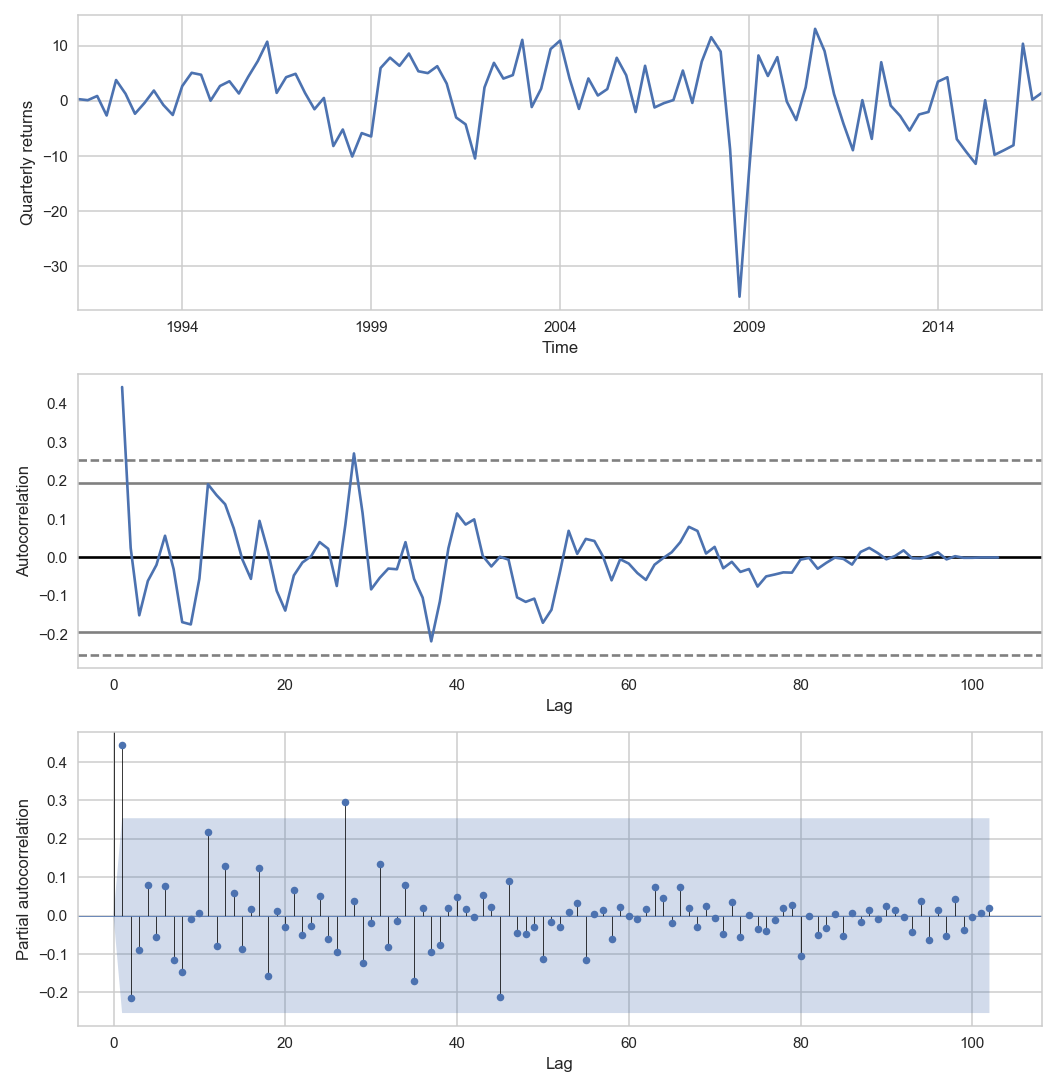

In [6]:
returns = 100 * data.pct_change(1).dropna()

fig = plt.figure(num='Returns on '+name+' and their (Partial) Autocorrelation', figsize=(9.7, 10))
return_ax = fig.add_subplot(311)
aucorr_ax = fig.add_subplot(312)
pacorr_ax = fig.add_subplot(313)

returns.plot(ax=return_ax)
return_ax.set_xlabel('Time')
return_ax.set_ylabel('Quarterly returns')

autocorrelation_plot(returns, ax=aucorr_ax)

plot_pacf(returns, alpha=0.01, ax=pacorr_ax, linewidth=0.5)
pacorr_ax.set_ylim(aucorr_ax.get_ylim())
pacorr_ax.set_xlim(aucorr_ax.get_xlim())
pacorr_ax.set_title('')
pacorr_ax.set_xlabel('Lag')
pacorr_ax.set_ylabel('Partial autocorrelation')

fig.tight_layout()

If neither autocorrelation nor partial autocorrelation significantly exceeds the confidence intervals at any lag, vanilla ARMA models are not going to do you much good. So let's also look at the *absolute* returns and _their_ (partial) autocorrelation next.

### Absolute returns and their autocorrelation

<IPython.core.display.Javascript object>


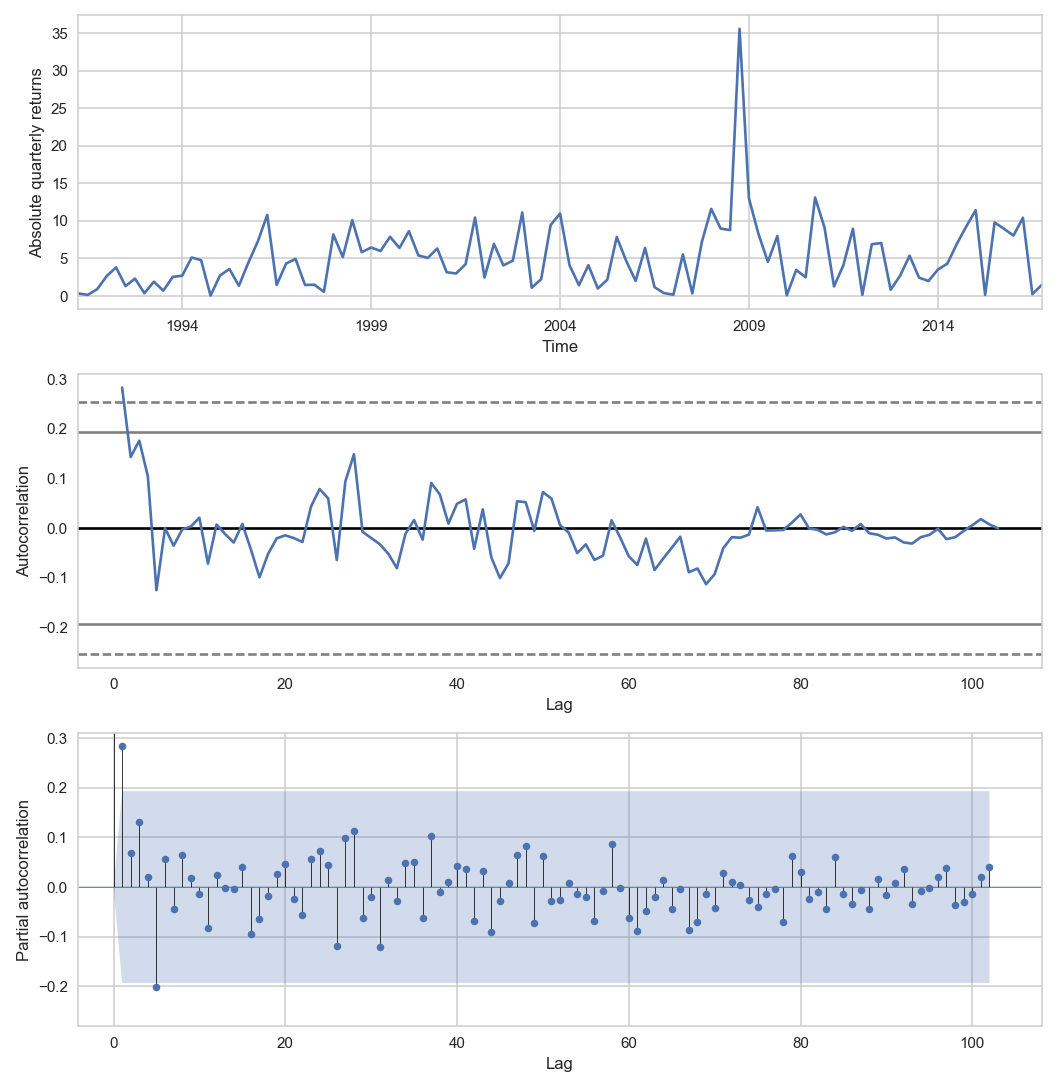

In [7]:
fig = plt.figure(num='Absolute Returns on '+name+' and their (Partial) Autocorrelation', figsize=(9.7, 10))
return_ax = fig.add_subplot(311)
aucorr_ax = fig.add_subplot(312)
pacorr_ax = fig.add_subplot(313)

returns.abs().plot(ax=return_ax)
return_ax.set_xlabel('Time')
return_ax.set_ylabel('Absolute quarterly returns')

autocorrelation_plot(returns.abs(), ax=aucorr_ax);

plot_pacf(returns.abs(), alpha=0.05, ax=pacorr_ax, linewidth=0.5)
pacorr_ax.set_ylim(aucorr_ax.get_ylim())
pacorr_ax.set_xlim(aucorr_ax.get_xlim())
pacorr_ax.set_title('')
pacorr_ax.set_xlabel('Lag')
pacorr_ax.set_ylabel('Partial autocorrelation')

fig.tight_layout()

If either the autocorrelation or the partial autocorrelation significantly exceeds the confidence intervals at any lag, then GARCH-type models on the volatility might be what we are looking for.

### Distribution of (absolute) returns 

<IPython.core.display.Javascript object>


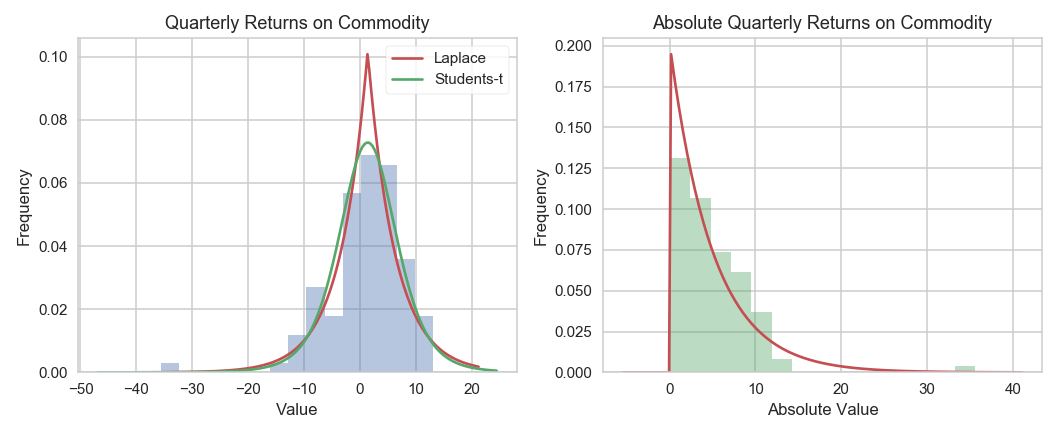

In [8]:
fig = plt.figure(num='Distribution of (Absolute) Returns on '+name, figsize=(9.7, 4))
returns_ax = fig.add_subplot(121)
absrtns_ax = fig.add_subplot(122)

sbn.distplot(returns, 
             bins=15, 
             kde=False, 
             fit=laplace, 
             fit_kws={'color': '#c44e52', 'label': 'Laplace'}, 
             ax=returns_ax);
returns_ax.set_title('Quarterly Returns on '+name)
returns_ax.set_xlabel('Value')
returns_ax.set_ylabel('Frequency')

sbn.distplot(returns.abs(), 
             bins=15, 
             kde=False, 
             fit=expon, 
             fit_kws={'color': '#c44e52'}, 
             color='#55a868', 
             ax=absrtns_ax); 
absrtns_ax.set_title('Absolute Quarterly Returns on '+name)
absrtns_ax.set_xlabel('Absolute Value')
absrtns_ax.set_ylabel('Frequency')

x_lims = returns_ax.get_xlim()
x_vals = np.linspace(*x_lims, 200)
params = t.fit(returns)
returns_ax.plot(x_vals, t.pdf(x_vals, *params), label='Students-t')
returns_ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.8)

fig.tight_layout()

Note that the tails of the (absolute) returns are *far* too fat for a Gaussian process.

## A Grand Tour of the Bayesian  `PyFlux` Package
In case you are wondering why we never touch the _priors_, it is because they seem to be fine for the data at hand. Nothing could express my belief better.
### ARMA models
#### Set up lag ranges and scan through all models to find the one with minimal BIC

In [10]:
maximumlag = 5  # Up to which lag-order should we test models?

timeseries = returns.values
drop_first = lambda lag_combi: timeseries[maximumlag - max(lag_combi.values()):]
lag_ranges = {'ar': range(maximumlag+1),
              'ma': range(maximumlag+1)}
lag_combis = (dict(zip(lag_ranges.keys(), values)) for values in product(*lag_ranges.values()))
ARMAmodels = (pf.ARIMA(drop_first(lags), **lags, family=pf.t()) for lags in lag_combis)

best_ARMA_model = best_of(ARMAmodels)
best_ARMA_model.fit().summary(transformed=False)

t ARIMA(3,0,4)                                                                                            
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 4                                           Log Likelihood: -287.5817                         
End Date: 101                                           AIC: 595.1635                                     
Number of observations: 98                              BIC: 621.0132                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 1.07       0.152      7.0401   0.0      (0.7721 | 1.3679)        
AR(1)                                

#### Perform Black Box Variational Inference and check its convergence
Consider increasing the number of iterations if you are not happy with what you see

10% done : ELBO is -330.144839374, p(y,z) is -309.269431837, q(z) is 20.8754075371
20% done : ELBO is -328.750847806, p(y,z) is -307.82778386, q(z) is 20.9230639463
30% done : ELBO is -326.691946028, p(y,z) is -305.752651599, q(z) is 20.9392944289
40% done : ELBO is -326.477826928, p(y,z) is -305.66358409, q(z) is 20.8142428379
50% done : ELBO is -325.217517246, p(y,z) is -304.361114031, q(z) is 20.8564032148
60% done : ELBO is -325.102827155, p(y,z) is -304.376211018, q(z) is 20.7266161376
70% done : ELBO is -324.679651389, p(y,z) is -304.101920165, q(z) is 20.5777312246
80% done : ELBO is -323.814223404, p(y,z) is -303.316782691, q(z) is 20.4974407137
90% done : ELBO is -323.381158321, p(y,z) is -302.972650528, q(z) is 20.4085077928
100% done : ELBO is -323.172018092, p(y,z) is -302.832193311, q(z) is 20.3398247814

Final model ELBO is -322.853755499


<IPython.core.display.Javascript object>


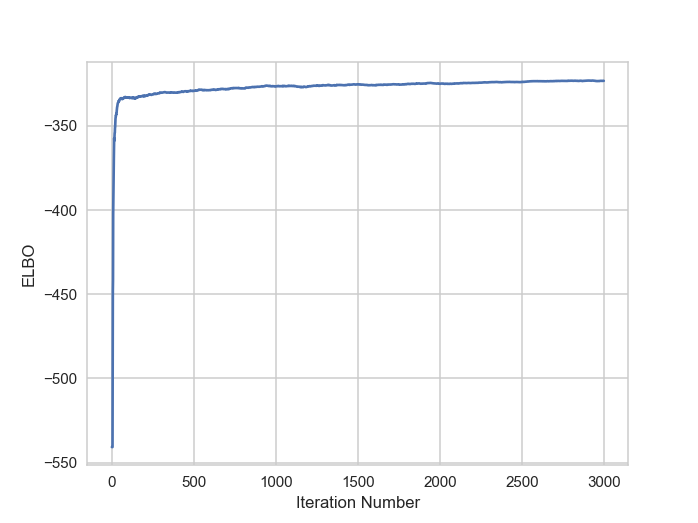

t ARIMA(3,0,4)                                                                                            
======================================================= ==================================================
Dependent Variable: Series                              Method: BBVI                                      
Start Date: 4                                           Unnormalized Log Posterior: -302.6911             
End Date: 101                                           AIC: 625.382123193                                
Number of observations: 98                              BIC: 651.23179798                                 
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Constant                                 0.9916             0.9914             (0.8773 | 1.1045)        
AR(1)                                    0.

In [11]:
ARMAresults = best_ARMA_model.fit(method='BBVI', map_start=True, record_elbo=True, iterations=3000)

fig, ax = plt.subplots()
ax.plot(ARMAresults.elbo_records)
ax.set_xlabel('Iteration Number')
ax.set_ylabel('ELBO')

ARMAresults.summary(transformed=False)

#### Plot fit to returns and forecast for a year

<IPython.core.display.Javascript object>


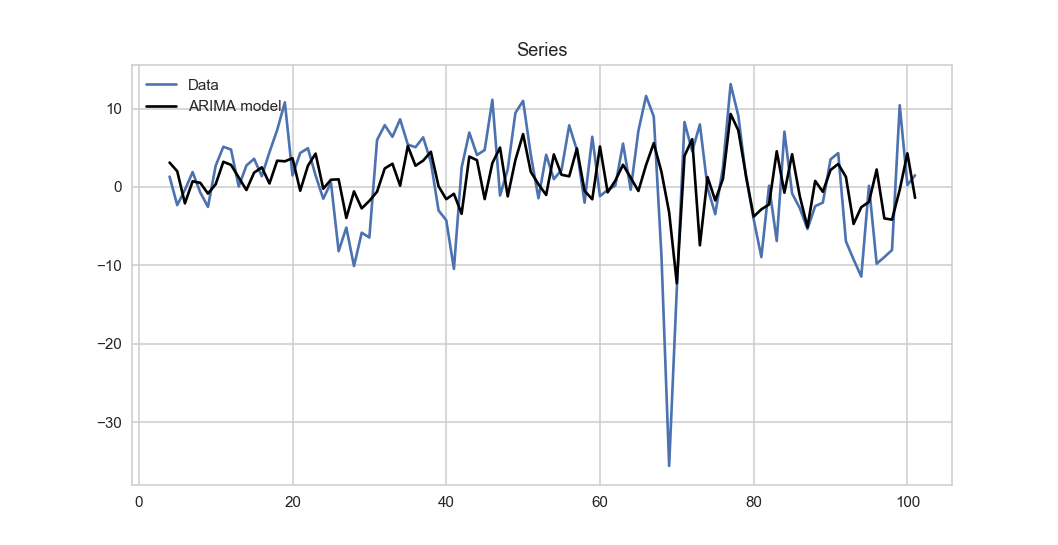

<IPython.core.display.Javascript object>


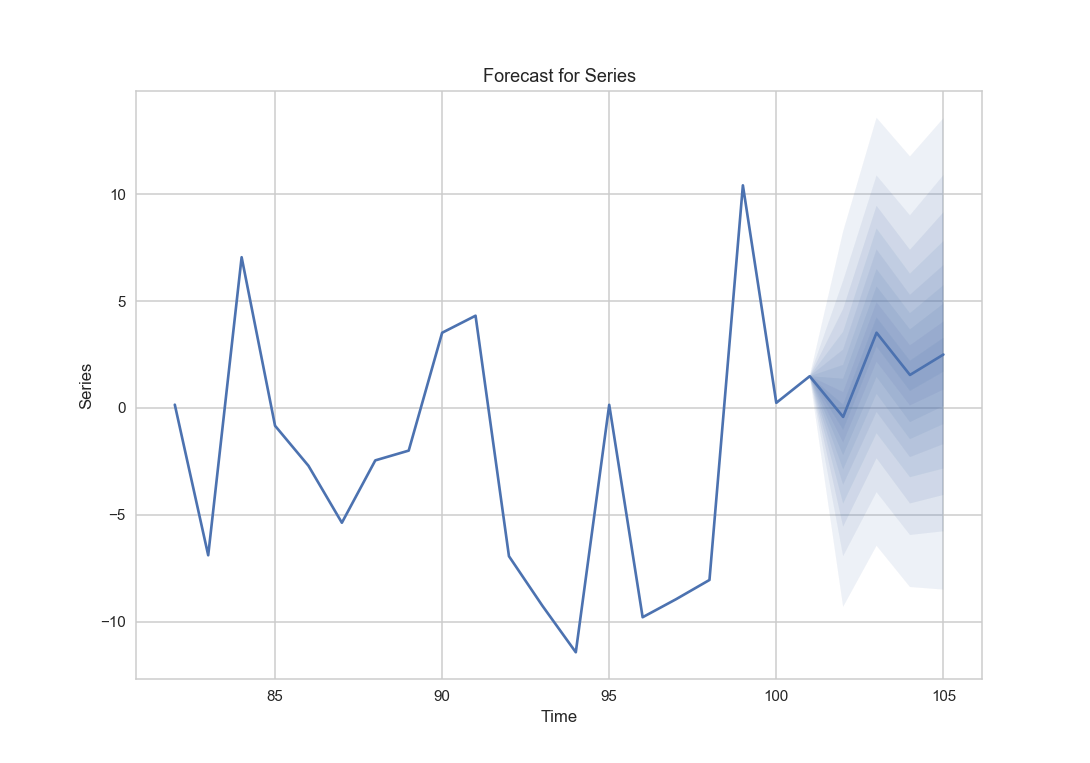

In [12]:
best_ARMA_model.plot_fit(figsize=(9.7, 5))
best_ARMA_model.plot_predict(h=4)
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### GARCH models
#### Set up model types and lag ranges to be scanned and find the one with minimal BIC
**Note**: SEGARCH and SEGARCHM models don't seem to always converge when fitted with MLE. Check before you include them!

In [13]:
maximumlag = 4  # Up to which lag-order should we test models?

timeseries = returns.values
drop_first = lambda lag_combi: timeseries[maximumlag - max(lag_combi.values()):]
lag_ranges = {'p': range(1, maximumlag+1),
              'q': range(maximumlag+1)}
modeltypes = (pf.GARCH, pf.EGARCH, pf.LMEGARCH)  # and pf.SEGARCH, pf.SEGARCHM, pf.EGARCHM ?
lag_combis = (dict(zip(lag_ranges.keys(), values)) for values in product(*lag_ranges.values()))
ARCHmodels = [model(drop_first(lags), **lags) for lags in lag_combis for model in modeltypes]

best_model = best_of(ARCHmodels)
best_leveraged_model = best_of(ARCHmodels, leverage=True)

best_results = best_model.fit()
best_leveraged_results = best_leveraged_model.fit()

if best_results.bic < best_leveraged_results.bic:
    best_ARCH_model = best_model
    best_results.summary(transformed=False)
else:
    best_ARCH_model = best_leveraged_model
    best_leveraged_results.summary(transformed=False)

EGARCH(1,1)                                                                                               
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: -313.6082                         
End Date: 99                                            AIC: 639.2163                                     
Number of observations: 99                              BIC: 654.7871                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             1.7301     0.5266     3.2856   0.001    (0.698 | 2.7621)         
ilogit(p(1))                         

#### Perform Black Box Variational Inference and check its convergence
Consider increasing the number of iterations if you are not happy with what you see

10% done : ELBO is -330.832355294, p(y,z) is -318.952394469, q(z) is 11.879960825
20% done : ELBO is -328.501288756, p(y,z) is -316.5990204, q(z) is 11.9022683558
30% done : ELBO is -328.487233213, p(y,z) is -316.552584214, q(z) is 11.9346489988
40% done : ELBO is -328.472457601, p(y,z) is -316.514407562, q(z) is 11.9580500391
50% done : ELBO is -328.614170183, p(y,z) is -316.706894456, q(z) is 11.9072757278
60% done : ELBO is -328.273177339, p(y,z) is -316.470256514, q(z) is 11.8029208255
70% done : ELBO is -328.371942725, p(y,z) is -316.512325304, q(z) is 11.8596174214
80% done : ELBO is -328.456436737, p(y,z) is -316.637567026, q(z) is 11.8188697112
90% done : ELBO is -328.149002727, p(y,z) is -316.368529142, q(z) is 11.780473585
100% done : ELBO is -328.365393325, p(y,z) is -316.704246625, q(z) is 11.6611466996

Final model ELBO is -327.799635763


<IPython.core.display.Javascript object>


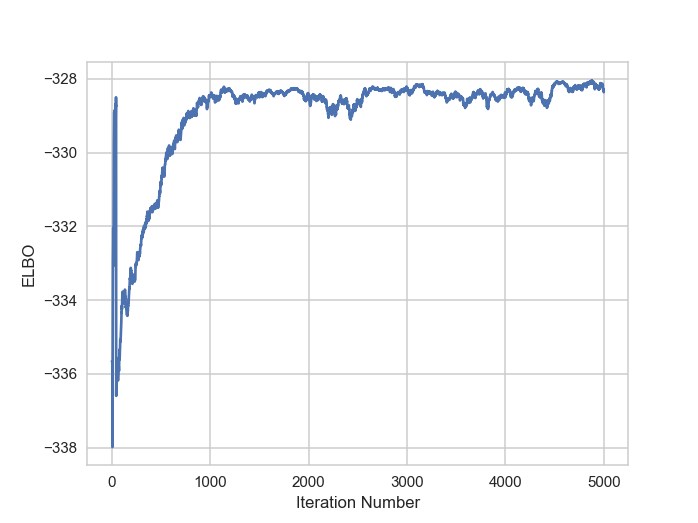

EGARCH(1,1)                                                                                               
======================================================= ==================================================
Dependent Variable: Series                              Method: BBVI                                      
Start Date: 1                                           Unnormalized Log Posterior: -316.422              
End Date: 99                                            AIC: 644.843922304                                
Number of observations: 99                              BIC: 660.414641404                                
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Vol Constant                             1.4693             1.4695             (1.3787 | 1.56)          
p(1)                                     0.

In [15]:
ARCHresults = best_ARCH_model.fit(method='BBVI', map_start=True, record_elbo=True, iterations=5000)

fig, ax = plt.subplots()
ax.plot(ARCHresults.elbo_records)
ax.set_xlabel('Iteration Number')
ax.set_ylabel('ELBO')

ARCHresults.summary(transformed=False)

#### Plot fit to volatility and forecast for a year

<IPython.core.display.Javascript object>


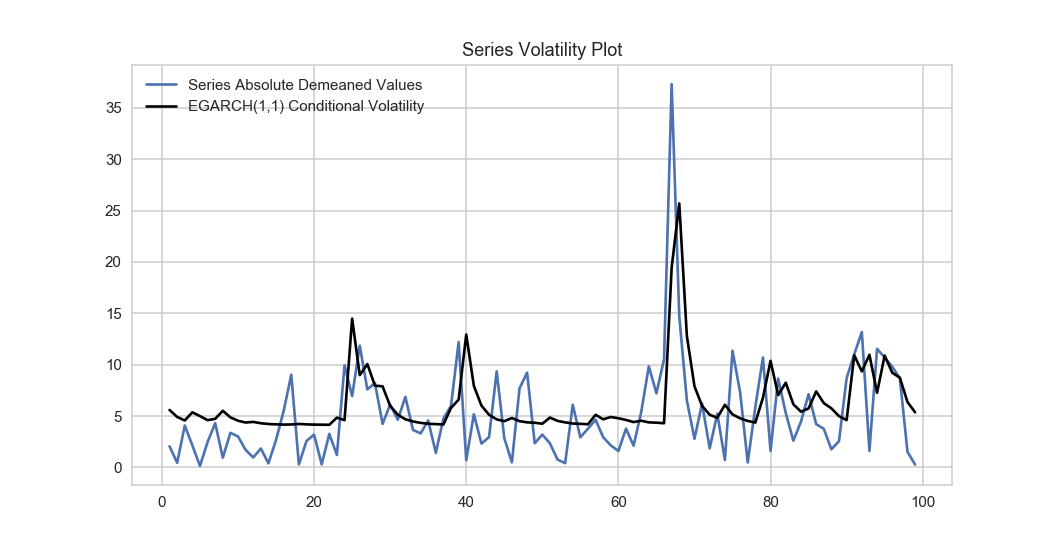

<IPython.core.display.Javascript object>


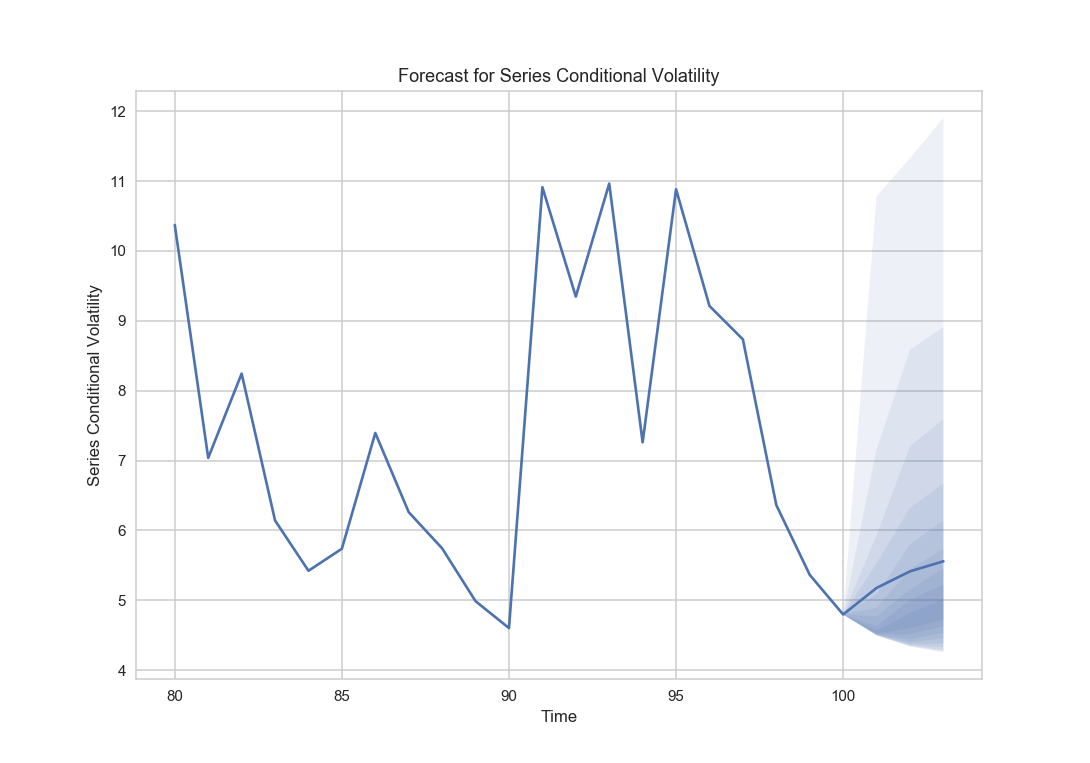

In [16]:
best_ARCH_model.plot_fit(figsize=(9.7, 5))
best_ARCH_model.plot_predict(h=4)
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### GAS models on the volatility ...
#### Set up lag ranges and scan through all models to find the one with minimal BIC

In [17]:
maximumlag = 4  # Up to which lag-order should we test models?

timeseries = returns.abs().values
drop_first = lambda lag_combi: timeseries[maximumlag - max(lag_combi.values()):]
lag_ranges = {'ar': range(maximumlag+1),
              'sc': range(maximumlag+1)}
lag_combis = (dict(zip(lag_ranges.keys(), values)) for values in product(*lag_ranges.values()))
GAS_models = (pf.GAS(drop_first(lags), **lags, family=pf.Poisson()) for lags in lag_combis)

best_GAS_model = best_of(GAS_models)
best_GAS_model.fit().summary(transformed=False)

PoissonGAS (3,0,2)                                                                                        
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 3                                           Log Likelihood: -291.6466                         
End Date: 101                                           AIC: 595.2931                                     
Number of observations: 99                              BIC: 610.8638                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 1.4517     0.6154     2.359    0.0183   (0.2456 | 2.6578)        
AR(1)                                

#### Sample posterior probability with MCMC
Consider increasing the number of simulated steps if the results are not converged

In [ ]:
GASresults = best_GAS_model.fit(method='M-H', map_start=True, nsims=10000)
best_GAS_model.latent_variables.trace_plot(figsize=(9.7, 10))
GASresults.summary(transformed=False)

Acceptance rate of Metropolis-Hastings is 0.0001
Acceptance rate of Metropolis-Hastings is 0.03145
Acceptance rate of Metropolis-Hastings is 0.47105
Acceptance rate of Metropolis-Hastings is 0.5381
Acceptance rate of Metropolis-Hastings is 0.2535

Tuning complete! Now sampling.


#### Plot fit to volatility and forecast for a year

<IPython.core.display.Javascript object>


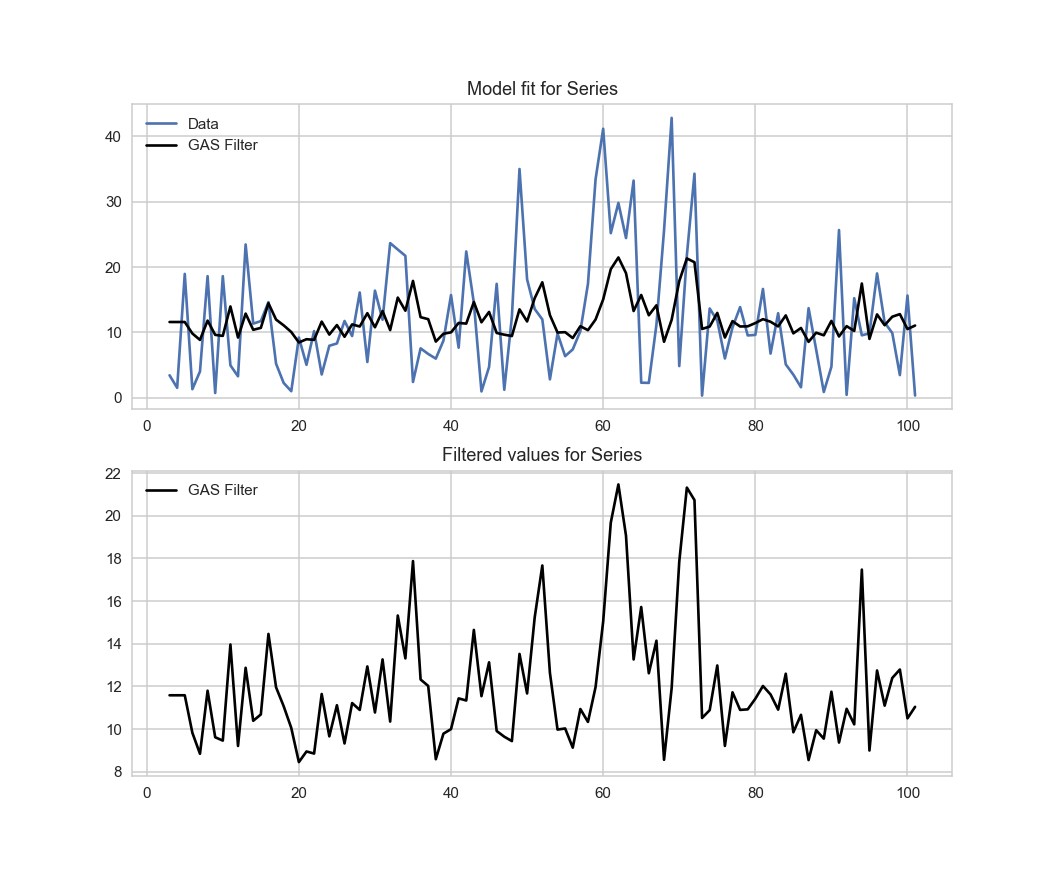

<IPython.core.display.Javascript object>


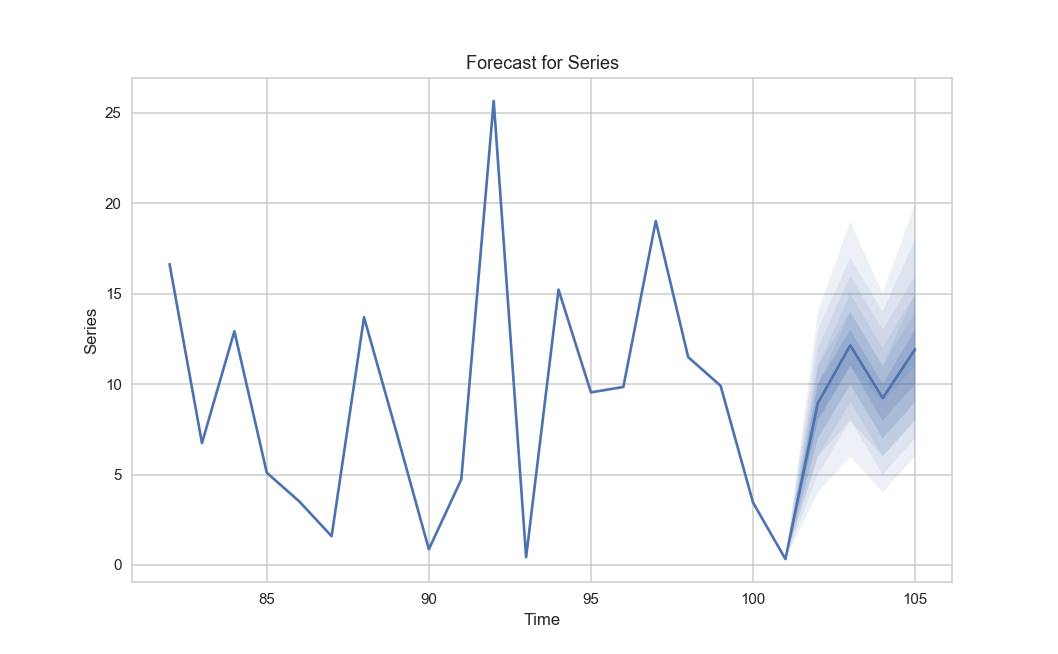

In [29]:
best_GAS_model.plot_fit(figsize=(9.7, 8))
best_GAS_model.plot_predict(h=4, figsize=(9.7, 6))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### ... and on the returns
#### Set up lag ranges and scan through all models to find the one with minimal BIC

In [30]:
maximumlag = 4  # Up to which lag-order should we test models?

timeseries = returns.values
drop_first = lambda lag_combi: timeseries[maximumlag - max(lag_combi.values()):]
lag_ranges = {'ar': range(maximumlag+1),
              'sc': range(maximumlag+1)}
lag_combis = (dict(zip(lag_ranges.keys(), values)) for values in product(*lag_ranges.values()))
GAS_models = (pf.GAS(drop_first(lags), **lags, family=pf.t()) for lags in lag_combis)

best_GAS_model = best_of(GAS_models)
best_GAS_model.fit().summary(transformed=False)

tGAS (1,0,1)                                                                                              
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: -392.9051                         
End Date: 99                                            AIC: 795.8102                                     
Number of observations: 99                              BIC: 808.7858                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 2.3929     0.0349     68.4738  0.0      (2.3244 | 2.4614)        
AR(1)                                

#### Perform Black Box Variational Inference and check its convergence
Consider increasing the number of iterations if the you are not happy with what you see

10% done : ELBO is -414.300258318, p(y,z) is -404.057924241, q(z) is 10.2423340776
20% done : ELBO is -414.285530564, p(y,z) is -404.019252805, q(z) is 10.2662777591
30% done : ELBO is -413.867700722, p(y,z) is -403.653020458, q(z) is 10.2146802641
40% done : ELBO is -413.576211158, p(y,z) is -403.348909806, q(z) is 10.2273013515
50% done : ELBO is -413.446573295, p(y,z) is -403.238231533, q(z) is 10.2083417618
60% done : ELBO is -413.259919156, p(y,z) is -403.087542689, q(z) is 10.1723764667
70% done : ELBO is -413.001398515, p(y,z) is -402.843588813, q(z) is 10.1578097019
80% done : ELBO is -412.790804808, p(y,z) is -402.681015537, q(z) is 10.1097892712
90% done : ELBO is -412.635560132, p(y,z) is -402.553017238, q(z) is 10.0825428942
100% done : ELBO is -413.472776714, p(y,z) is -403.448286931, q(z) is 10.0244897833

Final model ELBO is -412.886832743


<IPython.core.display.Javascript object>


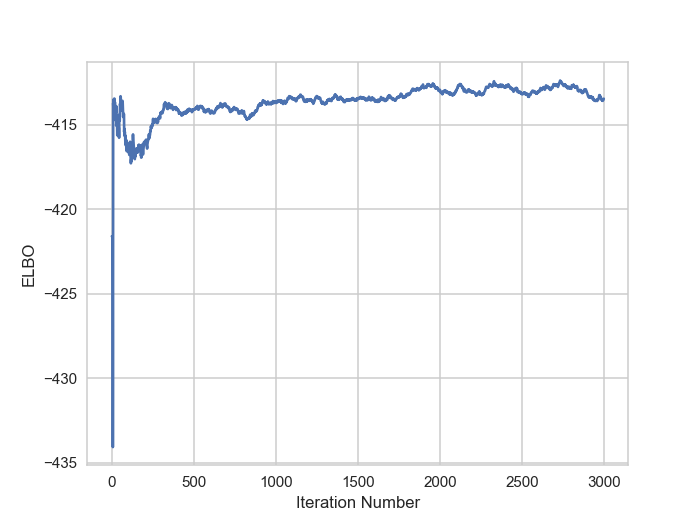

tGAS (1,0,1)                                                                                              
======================================================= ==================================================
Dependent Variable: Series                              Method: BBVI                                      
Start Date: 1                                           Unnormalized Log Posterior: -402.9466             
End Date: 99                                            AIC: 815.893113265                                
Number of observations: 99                              BIC: 828.868712515                                
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Constant                                 1.7422             1.7421             (1.5972 | 1.8876)        
AR(1)                                    -0

In [31]:
GASresults = best_GAS_model.fit(method='BBVI', map_start=True, record_elbo=True, iterations=3000)

fig, ax = plt.subplots()
ax.plot(GASresults.elbo_records)
ax.set_xlabel('Iteration Number')
ax.set_ylabel('ELBO')

GASresults.summary(transformed=False)

#### Plot fit to returns and forecast for a year

<IPython.core.display.Javascript object>


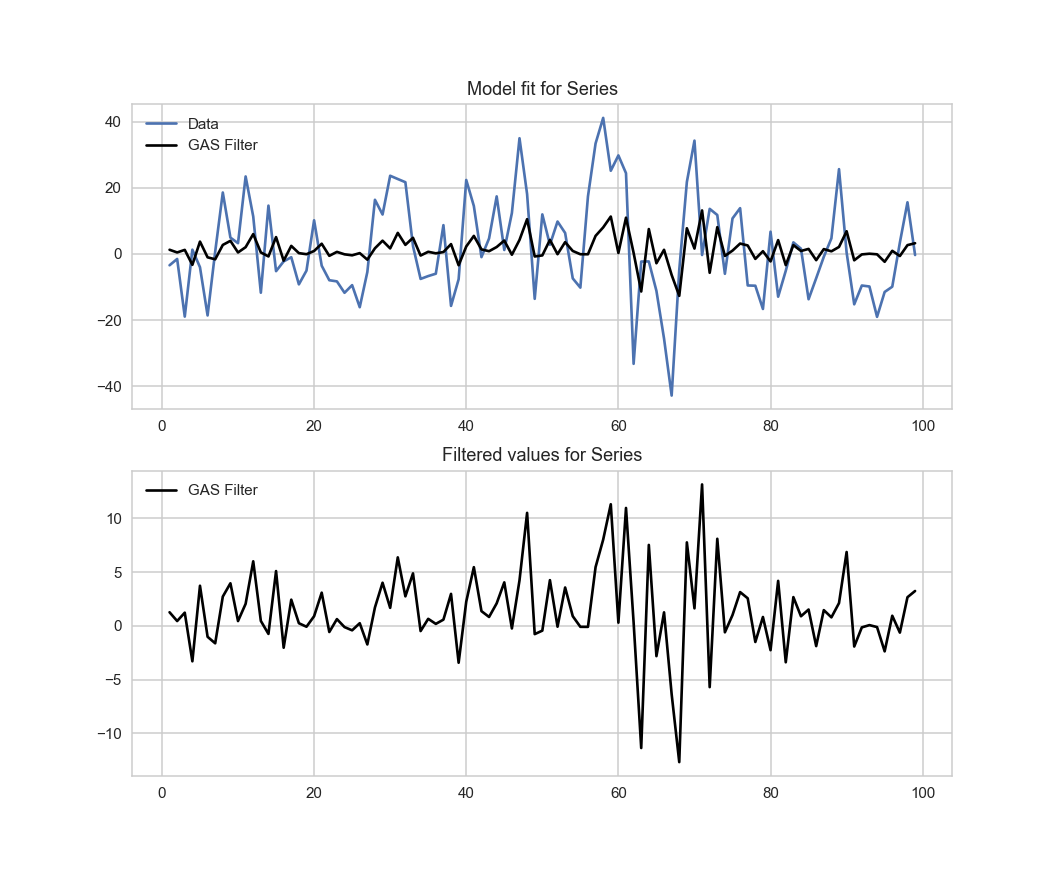

<IPython.core.display.Javascript object>


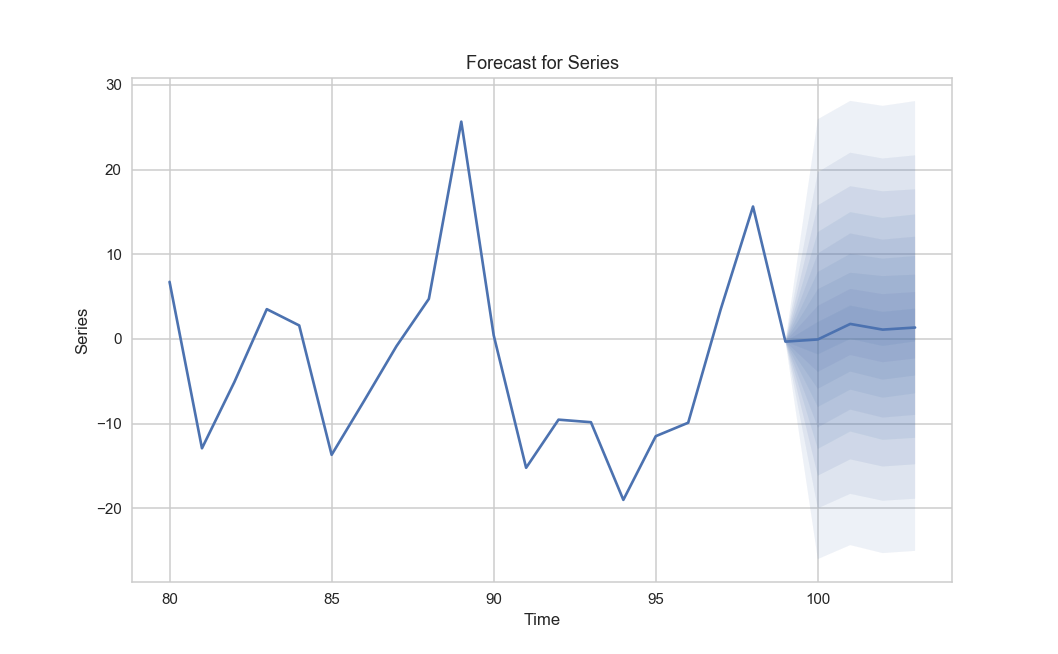

In [32]:
best_GAS_model.plot_fit(figsize=(9.7, 8))
best_GAS_model.plot_predict(h=4, figsize=(9.7, 6))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### GAS local-level model on the volatility
#### Find maximum-likelihood parameters first 

In [33]:
timeseries = returns.abs().values
GASLLmodel = pf.GASLLEV(timeseries, pf.Poisson())
GASLLEVres = GASLLmodel.fit()
GASLLEVres.summary(transformed=False)

Poisson GAS LLM                                                                                           
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: -565.8468                         
End Date: 102                                           AIC: 1133.6937                                    
Number of observations: 102                             BIC: 1136.3187                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
SC(1)                                    0.1734     0.0204     8.5027   0.0      (0.1334 | 0.2134)        


#### Sample posterior probability with MCMC
Consider increasing the number of simulated steps if the results are not converged

Acceptance rate of Metropolis-Hastings is 0.4466
Acceptance rate of Metropolis-Hastings is 0.3629

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.368825


<IPython.core.display.Javascript object>


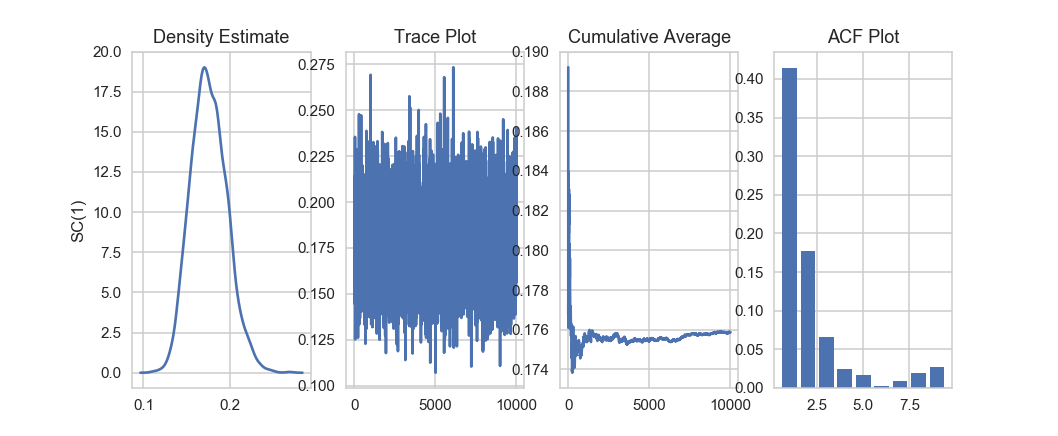

Poisson GAS LLM                                                                                           
======================================================= ==================================================
Dependent Variable: Series                              Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -565.2227             
End Date: 102                                           AIC: 1132.44547685                                
Number of observations: 102                             BIC: 1135.07044966                                
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
SC(1)                                    0.1749             0.1759             (0.1436 | 0.2113)        


In [34]:
GASLLEVres = GASLLmodel.fit(method='M-H', map_start=True, nsims=10000)
GASLLmodel.latent_variables.trace_plot(figsize=(9.7, 4))
GASLLEVres.summary(transformed=False)

#### Plot fit to volatility and forecast for a year

<IPython.core.display.Javascript object>


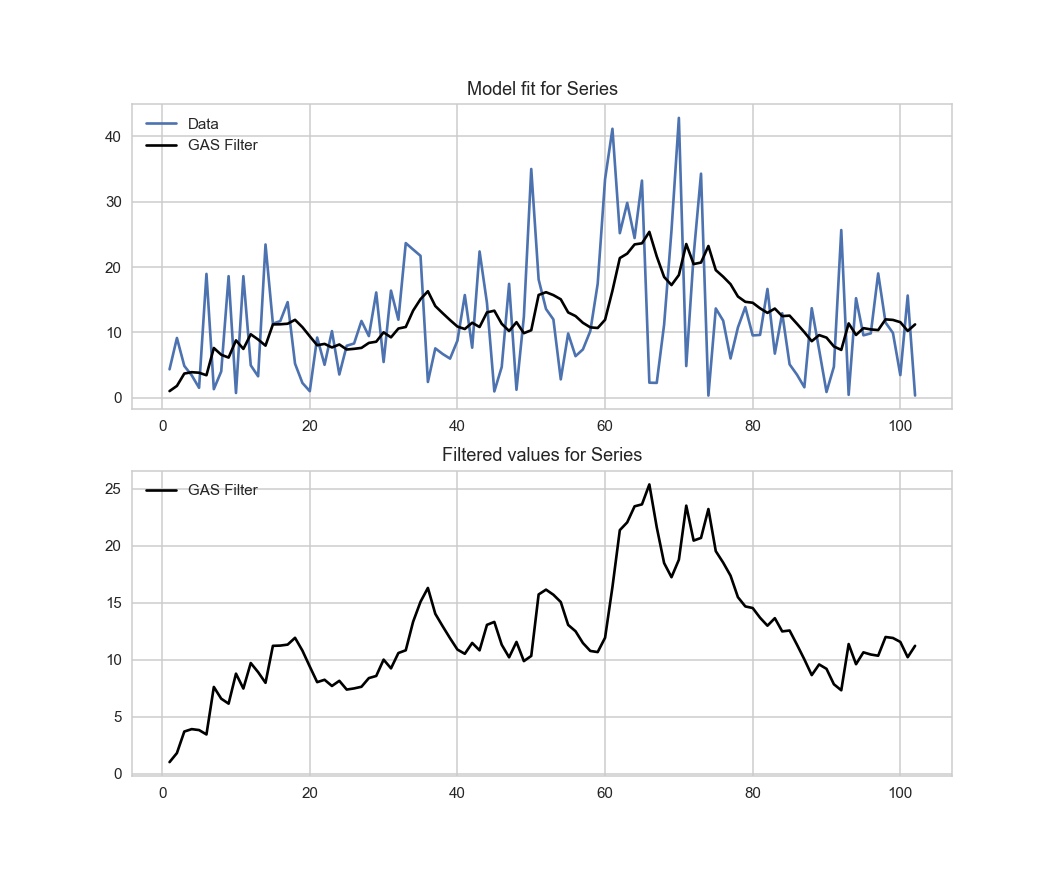

<IPython.core.display.Javascript object>


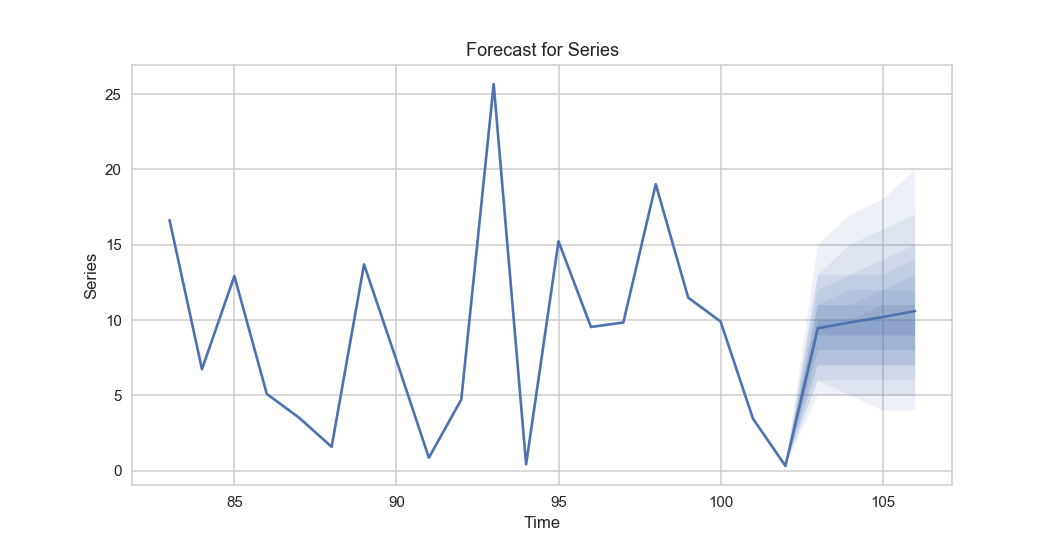

In [35]:
GASLLmodel.plot_fit(figsize=(9.7, 8))
GASLLmodel.plot_predict(h=4, figsize=(9.7, 5))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### GP-NARX models on the returns ...
#### Set up parameter ranges and scan through all models to find the one with minimal BIC
Note that not all kernels always lead to well-conditioned models

In [40]:
max_lag = 3  # Up to which lag-order should we test models?

tseries = returns.values
without = lambda ar: tseries[max_lag - ar:]
ar_lags = range(1, max_lag+1)
kernels = (pf.SquaredExponential(), pf.OrnsteinUhlenbeck(), pf.Periodic())#, pf.RationalQuadratic())
GPNARXs = (pf.GPNARX(without(lag), lag, kernel) for lag in ar_lags for kernel in kernels)

best_GPNARX_model = best_of(GPNARXs)
nkernel = str(best_GPNARX_model.kernel).split('.')[3].split(' ')[0]
results = best_GPNARX_model.fit()
results.summary(transformed=False)
print('BEST KERNEL IS', nkernel)

GPNARX(3)                                                                                                 
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 3                                           Log Likelihood: -134.1207                         
End Date: 102                                           AIC: 274.2415                                     
Number of observations: 100                             BIC: 282.057                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
log(Noise Sigma^2)                       -0.0972    1.6957     0.5351   0.5926   (-2.4163 | 4.231)        
log(l)                               

#### Plot fit to returns and forecast for a year

<IPython.core.display.Javascript object>


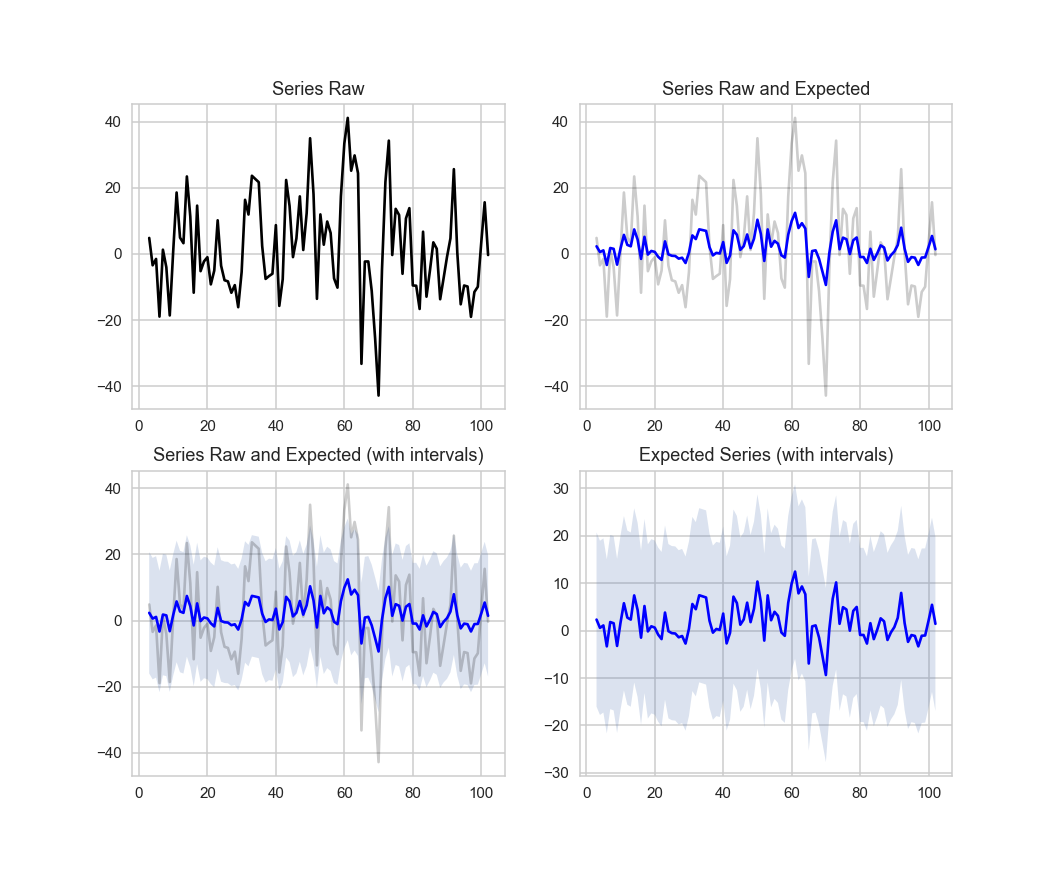

<IPython.core.display.Javascript object>


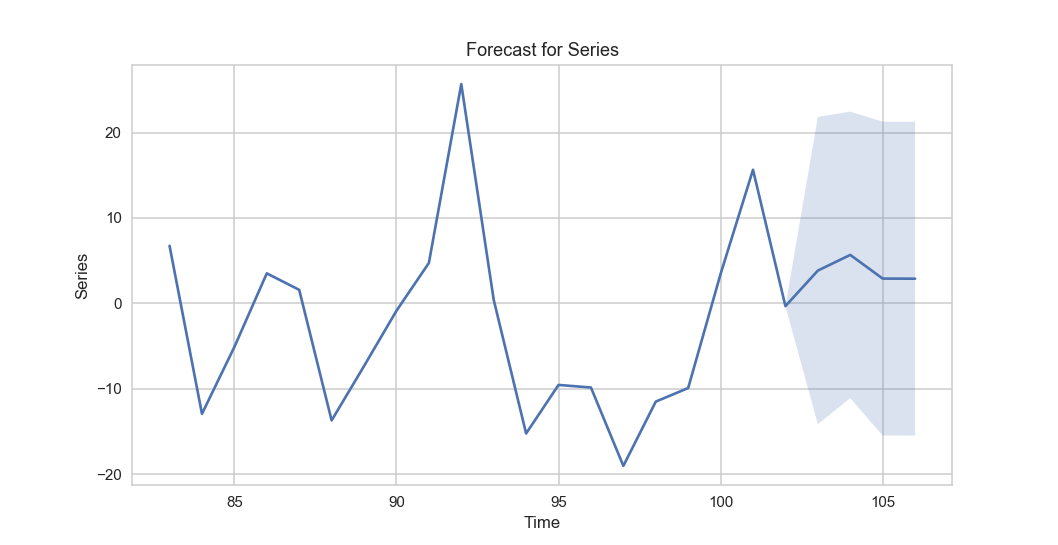

In [41]:
best_GPNARX_model.plot_fit(figsize=(9.7, 8))
best_GPNARX_model.plot_predict(h=4, figsize=(9.7, 5))
children = plt.gca().get_children() 
_ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

### VAR model
#### Set up parameter ranges and scan through all models to find the one with minimal BIC

In [44]:
maximumlag = 12  # Up to which lag-order should we test models?

timeseries = 100 * raw_data.loc[:, 'Energy':'Livestock'].resample('BQ').mean().pct_change(1).dropna()
drop_first = lambda ar_lag: timeseries.iloc[maximumlag - ar_lag:, :]
lag_orders = range(1, maximumlag+1)
VAR_models = (pf.VAR(drop_first(lag), lag) for lag in lag_orders)

min_bic, best_VAR_model = min((model.fit().bic, model) for model in VAR_models)
best_VAR_model.fit().summary(transformed=False)

VAR(1)                                                                                                    
======================================================= ==================================================
Dependent Variable: Energy,Precious Metals,Industrial M Method: OLS                                       
Start Date: 1994-06-30 00:00:00                         Log Likelihood: -4.80825346885e+14                
End Date: 2016-12-30 00:00:00                           AIC: 9.6165069377e+14                             
Number of observations: 91                              BIC: 9.6165069377e+14                             
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Energy Constant                          0.2531     1.3182     0.192    0.8477   (-2.3306 | 2.8369)       
Energy AR(1)                         

#### Perform Black Box Variational Inference and check its convergence
Consider increasing the number of iterations if the you are not happy with what you see

10% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 93.5911814442
20% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 93.8864827162
30% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 93.8808413105
40% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 94.0877435708
50% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 94.2507565755
60% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 94.446669867
70% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 94.1354780261
80% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 94.206857745
90% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 94.257247006
100% done : ELBO is -4.80825346885e+14, p(y,z) is -4.80825346885e+14, q(z) is 94.4549292475

Final model ELBO is -4.80825346885e+14


<IPython.core.display.Javascript object>


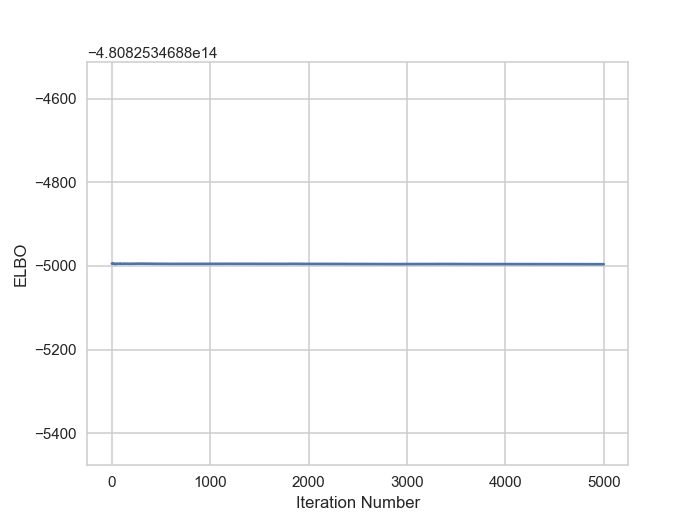

VAR(1)                                                                                                    
======================================================= ==================================================
Dependent Variable: Energy,Precious Metals,Industrial M Method: BBVI                                      
Start Date: 1994-06-30 00:00:00                         Unnormalized Log Posterior: -4.80825346885e+14    
End Date: 2016-12-30 00:00:00                           AIC: 9.6165069377e+14                             
Number of observations: 91                              BIC: 9.6165069377e+14                             
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Energy Constant                          0.2199             0.2202             (0.1445 | 0.2972)        
Energy AR(1)                             0.

In [45]:
VARresults = best_VAR_model.fit(method='BBVI', map_start=True, record_elbo=True, iterations=5000)

fig, ax = plt.subplots()
ax.plot(VARresults.elbo_records)
ax.set_xlabel('Iteration Number')
ax.set_ylabel('ELBO')

VARresults.summary(transformed=False)

#### Plot fit to returns and forecast for a year

In [ ]:
best_VAR_model.plot_fit(figsize=(9.7, 4))
best_VAR_model.plot_predict(h=4, figsize=(9.7, 4))
for figure in map(plt.figure, plt.get_fignums()[-5:]):
    children = plt.gca().get_children()
    _ = [child.set_facecolor('C0') for child in children if isinstance(child, PolyCollection)]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Concluding remarks

Returns dnot have local level (or linear trend) adn the data is not well described such models becasue the volatility of the random walk is not constant. Lastly, the onlinear local level models do not descibt the volatility well. Bayesian scores/evidence for the models would be nice.

What could work: Brent Crude (no GAS on returns), Aluminum (no GAS on returns), Copper (no GAS on returns), Zinc(no Gas returns), Silver(no Gas returns), Wheat(no Gas returns)

Nickel is gut?